# [[데이콘] 손동작 분류 경진대회](https://dacon.io/competitions/official/235876/data)

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore') # 경고 메시지 무시하고 숨기기

import matplotlib.pyplot as plt
# %matplotlib inline # 주피터 랩 내부에 그래프 실행

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

In [2]:
train = pd.read_csv('data/손동작 분류 경진대회/train.csv')
test = pd.read_csv('data/손동작 분류 경진대회/test.csv')
submission= pd.read_csv('data/손동작 분류 경진대회/sample_submission.csv')

In [3]:
gr_mu = train.groupby('target').mean().iloc[:, 1:]
gr_mu

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
target,,,,,,,,,,,,,,,,,,,,,
0,-0.425433,-0.922978,1.389976,0.559473,-0.694207,0.015784,0.793226,-0.913523,-0.561867,-0.802052,...,0.022476,-0.056393,-1.587852,-0.420015,0.905688,0.151944,-0.626062,-0.822711,-0.621473,-1.962038
1,-0.692796,-0.776260,-1.040046,-0.796645,-0.716867,-0.864049,0.217547,-0.588134,-0.795507,-0.470282,...,-0.727154,-0.841780,-0.605011,-0.622476,0.257340,-0.515845,-0.883002,-0.682358,0.154507,-0.607232
2,-2.346430,-0.822219,1.015480,0.079543,0.805130,-0.322211,-1.559588,-1.354339,-1.188115,-1.084991,...,0.926393,-0.561614,-0.598858,-0.591853,-2.619469,-0.660750,-0.706551,-0.714254,-0.997320,-0.504212
3,-0.983485,-1.559744,-3.951593,-0.422654,-0.727304,-0.518749,3.218229,-0.876624,-0.636275,-0.459929,...,-0.134662,0.026740,-0.935549,-0.714854,1.169092,-0.441372,-0.693405,-1.013212,-0.500214,0.046207


In [4]:
np.array(gr_mu.iloc[0]).reshape(8, 4)

array([[-0.42543341, -0.92297827,  1.38997599,  0.55947265],
       [-0.69420725,  0.01578392,  0.79322646, -0.91352322],
       [-0.56186682, -0.80205178, -1.59024312, -1.49077731],
       [-1.07621652, -1.28340279,  0.63719079, -1.48267005],
       [-0.4770604 , -0.30719699, -1.1636069 ,  0.04436227],
       [-0.71106263, -0.72865378,  0.02247641, -0.0563928 ],
       [-1.5878522 , -0.42001547,  0.90568842,  0.15194381],
       [-0.62606176, -0.8227112 , -0.62147315, -1.96203803]])

[plt.imshow 참고 자료](https://pyvisuall.tistory.com/78)

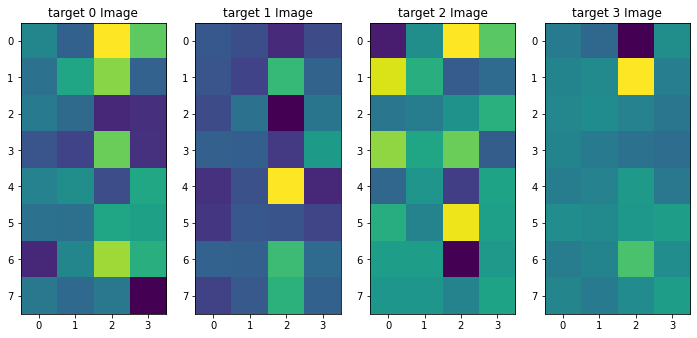

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 6))
for i in range(4):
    ax[i].set_title(f'target {i} Image')
    ax[i].imshow(np.array(gr_mu.iloc[i]).reshape(8, 4)) # 원하는 크기의 행렬을 만들어서 각 칸을 색으로 채우는 함수 or 이미지를 보기 위한 함수

target별로 어느 정도 다른 형태를 띈다고 볼 수 있다.

In [6]:
X = train.iloc[:, 1:-1]
target = test.iloc[:, 1:]

sensor1 ~ 32이기 때문에 8*4형태로 바꾸어준다.

In [7]:
X = np.array(X).reshape(-1, 8, 4, 1) # 구조 재배열
target = np.array(target).reshape(-1, 8, 4, 1) # 구조 재배열

MultiClass를 위해 target 값에 One-Hot 인코딩 취함

In [8]:
ohe = OneHotEncoder(sparse = False)

In [9]:
y = ohe.fit_transform(train[['target']]) # target 값을 가변수로 변환

In [10]:
y

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

[StratifiedKFold 참고 자료1](https://continuous-development.tistory.com/166)  
[StratifiedKFold 참고 자료2](https://velog.io/@skyepodium/K-Fold-%EA%B5%90%EC%B0%A8%EA%B2%80%EC%A6%9D)

- target에 속성값의 개수를 동일하게 가져감으로써 kFold처럼 데이터가 한 곳으로 몰리는 것 방지
- 분류 문제에서만 사용(회귀X)
- cross_val_score는 내부적으로 StratifiedKFold 사용

In [11]:
skf = StratifiedKFold(n_splits = 10, random_state= 42, shuffle=True) # shuffle=True: 데이터 분할 전 섞기

In [12]:
es = EarlyStopping(monitor='val_acc', patience = 5, mode = 'max', verbose = 0)